In [1]:
import pandas as pd

# Load the two CSV files
file1_path = '/Users/chaitanyatandon/Desktop/DREAM_11_v2/Dream-11/Code/Sohit/optimized_recent_form_odi.csv'
file2_path = '/Users/chaitanyatandon/Desktop/DREAM_11_v2/Dream-11/Code/Sohit/odi_match_wise_cumulated.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

/var/folders/fc/m5qlqlv518x0v2g6w7wjsh1w0000gn/T/ipykernel_34377/426237664.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(file1_path)
/var/folders/fc/m5qlqlv518x0v2g6w7wjsh1w0000gn/T/ipykernel_34377/426237664.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(file2_path)


In [2]:
# Merge the dataframes on 'match_id' and 'player_id'
merged_df = pd.merge(df1, df2, on=['match_id', 'player_id'], how='inner')  # Use 'inner', 'left', 'right', or 'outer'

# Display the first few rows of the merged dataframe
print(merged_df.head())

  match_id player_id player_name_x  team_name_x  runs_scored_x  balls_faced_x  \
0    64814  91a4a398        Z Khan        India             11             13   
1    64814  2764133a     L Vincent  New Zealand             34             32   
2    64814  b8a55852   BB McCullum  New Zealand              7             12   
3    64814  efc0a862     BF Bowden          NaN              0              0   
4    64814  f5390243   CD McMillan  New Zealand              5              7   

   no_of_fours_x  no_of_sixes_x  no_of_catches_x  runouts_x  ...  \
0              1              0                1          0  ...   
1              2              0                0          0  ...   
2              0              0                4          1  ...   
3              0              0                0          0  ...   
4              0              0                1          0  ...   

   batsman_average_runs_per_match  batsman_strike_rate  batsman_total_runs  \
0                         

In [3]:
output_file = 'merged_dataframe.csv'
merged_df.to_csv(output_file, index=False)

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define selected input features and target variable
selected_features = [
    'batsman_total_runs', 'recent_total_runs_odi', 'batsman_strike_rate',
    'recent_economy_rate_odi', 'bowler_economy_rate', 'batsman_100s',
    'bowler_wickets', 'batsman_50s', 'recent_total_wickets_odi',
    'batsman_average_runs_per_match'
]
target_variable = 'fantasy_points_x'

df= merged_df

# Drop rows with missing values
df = df.dropna(subset=selected_features + [target_variable])

# Retain match_id and player_id for output
identifier_columns = ['match_id', 'player_id']

# Ensure these columns exist
if not all(col in df.columns for col in identifier_columns):
    raise ValueError(f"The following columns must exist in the DataFrame: {identifier_columns}")

# Define input (X) and target (y)
X = df[selected_features + identifier_columns]  # Include match_id and player_id for later use
y = df[target_variable]

# Sequential split (80% for training, 20% for testing)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Retain match_id and player_id for output
X_test_identifiers = X_test[identifier_columns].reset_index(drop=True)

# Standardize the data (excluding identifier columns)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_test_scaled = scaler.transform(X_test[selected_features])

# Initialize Huber Regressor
huber = HuberRegressor()

# Train the model on the sequential split dataset
print("Training Huber Regression...")
huber.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = huber.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
non_zero_indices = y_test.values != 0  # Avoid division by zero
y_test_non_zero = y_test[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]
percentage_errors = np.abs((y_test_non_zero - y_pred_non_zero) / y_test_non_zero) * 100
mape = np.mean(percentage_errors)

# Print evaluation metrics
print("\nHuber Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Save player-wise predictions to a CSV file
playerwise_output = pd.DataFrame({
    'match_id': X_test_identifiers['match_id'],
    'player_id': X_test_identifiers['player_id'],
    'Actual_Fantasy_Points': y_test.values,
    'Predicted_Fantasy_Points': y_pred,
    'Absolute_Error': np.abs(y_pred - y_test.values),
    'Percentage_Error': np.abs((y_pred - y_test.values) / y_test.values) * 100  # Percentage error
}).reset_index(drop=True)

# Ensure 'match_id' is of a consistent type (e.g., string) before sorting
playerwise_output['match_id'] = playerwise_output['match_id'].astype(str)
playerwise_output = playerwise_output.sort_values(by='match_id')


# Save player-wise predictions
playerwise_output_file = 'playerwise_predictions.csv'
playerwise_output.to_csv(playerwise_output_file, index=False)
print(f"Player-wise predictions saved to '{playerwise_output_file}'")

# Group by match_id and calculate summary statistics
grouped_output = playerwise_output.groupby('match_id').agg({
    'Actual_Fantasy_Points': ['mean', 'sum', 'min', 'max'],  # Summary for actual points
    'Predicted_Fantasy_Points': ['mean', 'sum', 'min', 'max'],  # Summary for predicted points
    'Absolute_Error': ['mean', 'sum'],  # Summary for absolute error
})

# Calculate Percentage Error in Total Points
grouped_output['Total_Points_Percentage_Error'] = (
    (grouped_output[('Predicted_Fantasy_Points', 'sum')] - grouped_output[('Actual_Fantasy_Points', 'sum')]).abs()
    / grouped_output[('Actual_Fantasy_Points', 'sum')]
) * 100

# Flatten multi-level columns for better readability
grouped_output.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_output.columns]
grouped_output = grouped_output.reset_index()

# Save grouped predictions
grouped_output_file = 'grouped_predictions.csv'
grouped_output.to_csv(grouped_output_file, index=False)
print(f"Grouped predictions saved to '{grouped_output_file}'")


Training Huber Regression...

Huber Regression Results:
Mean Squared Error (MSE): 1595.23
R-squared (R2): 0.11
Mean Absolute Error (MAE): 27.51
Mean Absolute Percentage Error (MAPE): 235.06%
Player-wise predictions saved to 'playerwise_predictions.csv'
Grouped predictions saved to 'grouped_predictions.csv'


/var/folders/fc/m5qlqlv518x0v2g6w7wjsh1w0000gn/T/ipykernel_34377/663348071.py:81: RuntimeWarning: divide by zero encountered in divide
  'Percentage_Error': np.abs((y_pred - y_test.values) / y_test.values) * 100  # Percentage error


In [7]:
import pandas as pd

# Replace 'file_path.csv' with the actual path to your CSV file
file_path = 'grouped_predictions.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())


   match_id  Actual_Fantasy_Points_mean  Actual_Fantasy_Points_sum  \
0   1297947                       37.92                        948   
1   1297948                       42.92                       1073   
2   1297949                       41.20                       1030   
3   1297950                       45.68                       1142   
4   1297951                       36.80                        920   

   Actual_Fantasy_Points_min  Actual_Fantasy_Points_max  \
0                          0                        109   
1                          0                        129   
2                          0                        195   
3                          0                        225   
4                          0                         88   

   Predicted_Fantasy_Points_mean  Predicted_Fantasy_Points_sum  \
0                      29.340404                    733.510095   
1                      25.872758                    646.818954   
2                      29.

Statistics:
Mean: 35.41826313874554
Median: 25.753552036937183
Standard Deviation: 134.44575487231089


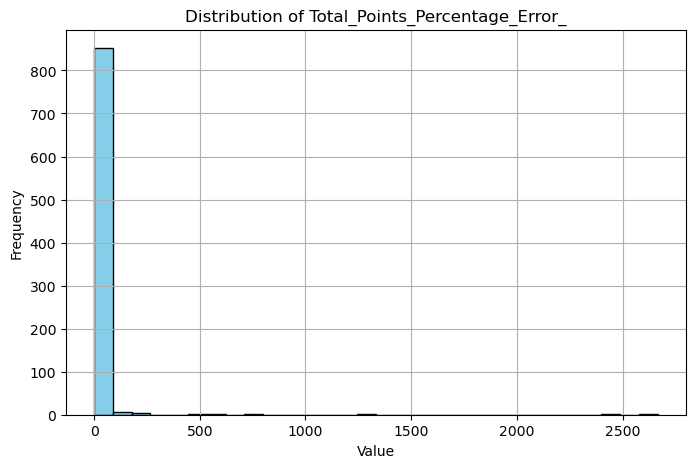


Summary Table:
            Statistic       Value
0                Mean   35.418263
1              Median   25.753552
2  Standard Deviation  134.445755


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
field = 'Total_Points_Percentage_Error_'

# 1. Calculate statistics
mean_value = df[field].mean()
median_value = df[field].median()
std_deviation = df[field].std()

# Display statistics
print("Statistics:")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")

# 2. Plot the distribution
plt.figure(figsize=(8, 5))
plt.hist(df[field], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total_Points_Percentage_Error_')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Tabular summary
summary_table = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Standard Deviation'],
    'Value': [mean_value, median_value, std_deviation]
})
print("\nSummary Table:")
print(summary_table)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   match_id                        868 non-null    int64  
 1   Actual_Fantasy_Points_mean      868 non-null    float64
 2   Actual_Fantasy_Points_sum       868 non-null    int64  
 3   Actual_Fantasy_Points_min       868 non-null    int64  
 4   Actual_Fantasy_Points_max       868 non-null    int64  
 5   Predicted_Fantasy_Points_mean   868 non-null    float64
 6   Predicted_Fantasy_Points_sum    868 non-null    float64
 7   Predicted_Fantasy_Points_min    868 non-null    float64
 8   Predicted_Fantasy_Points_max    868 non-null    float64
 9   Absolute_Error_mean             868 non-null    float64
 10  Absolute_Error_sum              868 non-null    float64
 11  Total_Points_Percentage_Error_  868 non-null    float64
dtypes: float64(8), int64(4)
memory usage

In [12]:
# Replace 'Match_ID' with the actual column name for match IDs in your DataFrame
match_id_column = 'match_id'


# Filter rows where Total_Points_Percentage_Error_ > 500
filtered_df = df[df['Total_Points_Percentage_Error_'] > 500]

# Extract the Match IDs
match_ids = filtered_df[match_id_column]

# Display the results
print("Match IDs where Total_Points_Percentage_Error_ > 500%:")
print(match_ids.tolist())


Match IDs where Total_Points_Percentage_Error_ > 500%:
[1322279, 1348328, 1398272, 1427836, 1450707]


In [15]:
print(df.shape[0])

868


In [16]:
X_train.head()

,batsman_total_runs,recent_total_runs_odi,batsman_strike_rate,recent_economy_rate_odi,bowler_economy_rate,batsman_100s,bowler_wickets,batsman_50s,recent_total_wickets_odi,batsman_average_runs_per_match,match_id,player_id
0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,64814,91a4a398
1,0,0,0.0,0.0,0.0,0,0,0,0,0.0,64814,2764133a
2,0,0,0.0,0.0,0.0,0,0,0,0,0.0,64814,b8a55852
3,0,0,0.0,0.0,0.0,0,0,0,0,0.0,64814,efc0a862
4,0,0,0.0,0.0,0.0,0,0,0,0,0.0,64814,f5390243
